# Week 11 (Aaron Kohn)
http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

## Exercise 13-1

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import survival

In [2]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0
    
    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10
    resp['marriage_agegroup'] = resp['agemarry'] // 10

In [3]:
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()
month0 = pd.to_datetime('1899-12-15')

CleanData(resp6)
resp6 = resp6[resp6['cmmarrhx'].notna()]
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
resp7 = resp7[resp7['cmmarrhx'].notna()]
married7 = resp7[resp7.evrmarry==1]


In [4]:
marrieds = [married6, married7]
marrieds_df = pd.concat(marrieds, ignore_index= True)
divorced = marrieds_df[marrieds_df.notdivorced == 0].duration.dropna()
still_married = marrieds_df[marrieds_df.notdivorced == 1].durationsofar.dropna()
cdf = thinkstats2.Cdf(marrieds_df.duration, label= 'cdf')

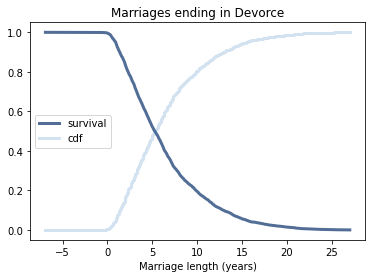

In [5]:
sf_divorce = survival.MakeSurvivalFromCdf(cdf)
thinkplot.Plot(sf_divorce, label='survival')
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left',
                 title= 'Marriages ending in Devorce',
                xlabel= 'Marriage length (years)')

In [6]:
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp.duration.dropna()
    ongoing = resp.durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf
def ResampleSurvival(resp, iters=1001):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
  #  _, sf = EstimateMarriageSurvival(resp)
   # thinkplot.Plot(sf)

    low, high = resp.duration.min(), resp.duration.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for i in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        hf, sf = EstimateSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

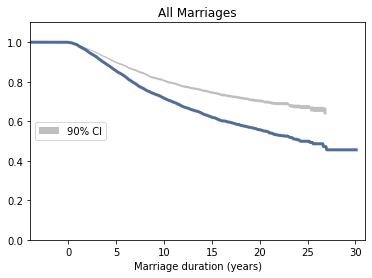

In [7]:
# Solution goes here
hf_divorce=survival.EstimateHazardFunction(divorced, still_married, label= '')
sfd = hf_divorce.MakeSurvival()
thinkplot.Plot(sfd)
ResampleSurvival(marrieds_df)
thinkplot.Config(xlabel= 'Marriage duration (years)', title= 'All Marriages', axis= [-4., 31., 0, 1.1])

In [8]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.
    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.
    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, column,iters=101, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby(column)

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateSurvivalByDecade(groups, alpha=0.2)

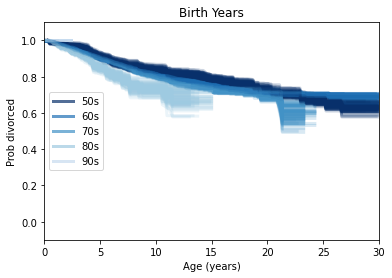

In [9]:
PlotResampledByDecade(marrieds, 'decade')
thinkplot.Config(xlabel='Age (years)',
                   ylabel='Prob divorced',
                   title= 'Birth Years',
                   xlim=[0, 30],
                   ylim=[-0.1, 1.1])

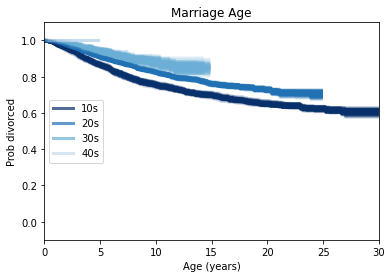

In [10]:
PlotResampledByDecade(marrieds, 'marriage_agegroup')
thinkplot.Config(xlabel='Age (years)',
                   ylabel='Prob divorced',
                   title= 'Marriage Age',
                   xlim=[0, 30],
                   ylim=[-0.1, 1.1])